# **ICG-PIXEL PERSONA**

## **WINTER PROJECT**

### **Loading necessary libraries**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


### **Initial Parameters**

In [ ]:
epochs = 50

lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []


### **Load image files from the dataset and Labelling the categories**

In [ ]:
image_files = [f for f in glob.glob(r'D:\pixel persona\Gender-Detection-master\Gender-Detection-master\gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)

    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0

    labels.append([label]) # [[1], [0], [0], ...]


### **Pre-Processing and splitting dataset**

In [ ]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# augmenting datset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


### **Model building and normalisation**

In [ ]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first",
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Training abd compiling the model**

In [ ]:
# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6751 - loss: 0.9111 - val_accuracy: 0.4935 - val_loss: 0.9617
Epoch 2/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 25s 943ms/step - accuracy: 0.7656 - loss: 0.4692

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7656 - loss: 0.4692 - val_accuracy: 0.4935 - val_loss: 1.0047
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8187 - loss: 0.4549 - val_accuracy: 0.4935 - val_loss: 1.2361
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7656 - loss: 0.5996 - val_accuracy: 0.4935 - val_loss: 1.2247
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8404 - loss: 0.3946 - val_accuracy: 0.6147 - val_loss: 0.6544
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8438 - loss: 0.4569 - val_accuracy: 0.6970 - val_loss: 0.6332
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8607 - loss: 0.3628 - val_accuracy: 0.5130 - val_loss: 0.7411
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8750 - loss: 0.3141 - val_accuracy: 0.5087 - val_loss: 0.7596
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8731 - loss: 0.3290 - val_accuracy: 0.5606 - val_loss: 0.9951

### **Saving the model in Disk**

In [ ]:
model.save(r'D:\pixel persona\gender_detection.keras')

###**Ploting  training,validation ,loss and accuracy of the prediction model**


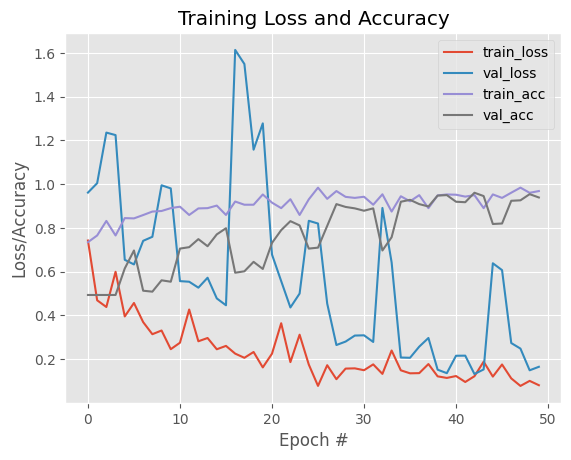

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")



### **From the graph we can see that training_loss(red) and validation_loss(blue) both are very less almost 0.1**